# Project 2: Segmentation

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Setting up PyMaxFlow: <span style="color:red;">45 min</span>
* 2. Getting your first successful segmentation: <span style="color:red;">2 hrs</span>
* 3. Adjusting parameters (e.g. $\lambda$, $\sigma$) and so forth, to get good results: <span style="color:red;">3 hrs</span>
* 4. Completing the write-up: <span style="color:red;">30 min</span>

Note that there are two folds within the project.  We have provided some images for you to use in testing your implementation, in the `provided images` folder along with their ground-truth segmentations to compare your results to.  Along with these, we want you to provide 2-4 additional images that you select on which you show your results.  <i>Please use the `provided_images` in that path and place any others in the `user_data` folder, and load all of the images (or user input point location files) via the approapriate relative path.  We will drop your notebook file and your `user_data` folder into our folder (which will have the `provided_images` already) and then run your notebook.</i>




## Preparation:
So that you can focus on the elements of the cost function ( the link weights), you may use a existing implementation of the actual min-cut algorithm itself.  You set up the graph, but it will take care of finding the minimum cut.

For this assignment we will be using a python library called PyMaxFlow.  This library is a python wrapper around the original C++ implementation of the min-cut code from [Vladimir Kolmogorov](http://pub.ist.ac.at/%7Evnk/software.html) (who has co-authored several papers on this subject).    

Note: For windows users, you will need the Visual C++ compiler in order for PyMaxFlow to work.  If you already have Visual Studio, this shouldn't be a problem but if you just want the compiler without Visual Studio, you can download [Build Tools For Visual Studio 2017](https://visualstudio.microsoft.com/downloads/#build-tools-for-visual-studio-2017). Once you have access to the Visual C++ compiler look at the next paragraph for PyMaxFlow installation.

PyMaxFlow requires Cython, which should come standard in your anaconda environment but the command to install that will also be included.  To install PyMaxFlow enter the following commands replacing "YourEnvironmentName" with the name of your anaconda environment.
~~~
conda activate YourEnvironemntName
conda install cython
pip install pymaxflow
~~~
Once PyMaxFlow is installed, to understand how to use the library, there is a great [tutorial page](http://pmneila.github.io/PyMaxflow/tutorial.html) that shows how to get started with some simple examples.  Do the "first example" and perhaps the "binary image restoration" as well.

## Annotations:
Graph cut segmentation is an interactive algorithm requiring the user to provide foreground and background seeds.  Provided is a python file that will open a gui and allow you to annotate the image.  This gui is optional and will require additional packages to be installed into your environment.  To install the packages open a terminal and enter the following commands:
~~~
conda activate YourEnvironmentName
conda install scikit-image pillow
~~~
You can use the gui in the following way:
```python
import guiseg
fore, back = guiseg.get_fore_back(image)
image[fore]  # the foreground seeds
image[back]  # the background seeds
```


## Graph Cut:
Your code should read in an image and a set of seed pixels and use graph-cut segmentation to segment the image.

You will need to calculate the costs for the t-links (region terms) and the n-links (boundary terms). See the book, the notes/slides, or published papers in this area for ideas of how to define these.  Remember that the t-link weights to a particular terminal (foreground or background) should be large if that pixel looks a lot like the respective foreground/background seeds. The n-link weights should be large if the two neighboring pixels are similar.

Here is [the original paper on graph-cut segmentation](http://www.csd.uwo.ca/~yuri/Papers/iccv01.pdf), which might help with some ideas, but you should look at the literature to see what other costs functions / link weights others have used.

Once the graph is built, use the min-cut algorithm to partition the graph into nodes connected to the foreground node or to the background node, then use these as the resulting labels for the segmentation. Display this result graphically in some fashion overlaid on the input image.  It is best to start with simple images whose foreground and background colors are pretty different and for ones where the edges are pretty clear.  Graph-cut segmentation struggles sometimes with long, thin structures, so you should avoid these types of images early on.



In [1]:
import maxflow
import guiseg
import cv2
from sklearn.neighbors.kde import KernelDensity
from math import e
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

def sampleSeeds(seeds):
    MAX_SAMPLE_SIZE = 200
    #if alot of seeds, take random sample
    if len(seeds) > MAX_SAMPLE_SIZE:
        idx = np.random.randint(len(seeds), size=MAX_SAMPLE_SIZE)
        seeds = seeds[idx, :]
    return seeds

def getUserInput(filePath):
    image = cv2.imread(filePath)
    image = image[:,:,::-1]
    fore, back = guiseg.get_fore_back(image)
    return image, image[fore], image[back], fore, back

def bCost(pixel_1, pixel_2, sigmaB, lambdaVal):
    norm = np.linalg.norm(pixel_1 - pixel_2)
    cost = lambdaVal * (e**( (-(norm**2)) / (2*(sigmaB**2)) ))
#     print(lambdaVal, sigmaB)
#     print("bcost: ", cost)
    return cost

def rCost(dist, pixel):
    pixel = pixel.reshape(1, -1)
    cost = -dist.score(pixel)
#     print("rcost: ", cost)
    return cost

def segmentation(image, fgSeeds, bgSeeds, lambdaVal, sigmaB):
    rows = image.shape[0]
    cols = image.shape[1]
        
    #make graph
    numNodes = rows * cols
    numEdges = numNodes * 3
    g = maxflow.Graph[float](numNodes, numEdges)
    nodeids = g.add_grid_nodes((rows,cols))
    
    #make distributions
    foreDist = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(fgSeeds)
    backDist = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(bgSeeds)
    
    #Iterate through the pixels making edges to right and down neighbors
    #Make edges to Foreground(source) and background(sink) nodes
    for r in range(rows):
        for c in range(cols):
            
            #if theres a right neighbor
            if c != cols - 1:
                currPixel = image[r,c]
                rightPixel = image[r,c+1]        
                #calculate cost to/from right neighbor
                costRight = bCost(currPixel, rightPixel, sigmaB, lambdaVal)
                #add cost to/from right neighbor
                g.add_edge(nodeids[r][c], nodeids[r][c+1], costRight, costRight)
            
            #if there's a down neighbor
            if r != rows -1:
                currPixel = image[r,c]
                downPixel = image[r+1, c]
                #calculate cost to/from down neighbor
                costDown = bCost(currPixel, downPixel, sigmaB, lambdaVal)
                #add cost to/from down neighbor
                g.add_edge(nodeids[r][c], nodeids[r+1][c], costDown, costDown)
            
            #calculate cost from foreground(source) to current pixel
            sourceCost = rCost(foreDist, image[r,c])
            #calculate cost from current pixel to background(sink)
            sinkCost = rCost(backDist, image[r,c])
            #add cost from foreground(source) to current pixel and from current pixel to background(sink)
            g.add_tedge(nodeids[r][c], sourceCost, sinkCost)
    
    #find the min cut (max flow)
    flow = g.maxflow()
    
    #iterate through pixels
    result = np.zeros((rows, cols), dtype=int)
    for r in range(rows):
        for c in range(cols):
            #if foreground(source)
            if g.get_segment(nodeids[r][c]) == 1:
                #make this pixel white
                result[r,c] = 255
            #else background(sink)
            else:
                result[r,c] = 0
    return result

## Results:

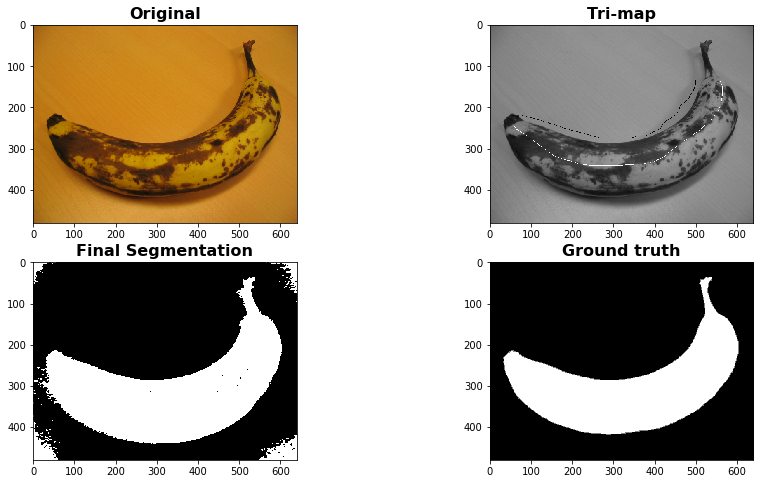

In [46]:
# ------------------- code to get and store new user input ----------------------------#
# image, fgSeeds, bgSeeds, fore, back = getUserInput("./provided_images/banana.png")
# tri_map = np.zeros((image.shape[0], image.shape[1], image.shape[2]), dtype=float)
# tri_map[:] = image
# tri_map = np.dot(tri_map, (0.299, 0.587, 0.114))
# tri_map[fore] = 255
# tri_map[back] = 0
# np.save('./user_data/bananaFGseeds', fgSeeds)
# np.save('./user_data/bananaBGseeds', bgSeeds)
# np.save('./user_data/bananaTriMap', tri_map)

# ------------------- code to load previous user input ----------------------#
fgSeeds = np.load('./user_data/bananaFGseeds.npy')
bgSeeds = np.load('./user_data/bananaBGseeds.npy')
tri_map = np.load('./user_data/bananaTriMap.npy')
image = np.load('./user_data/banana.npy')

# ------------------- code to compute the segmentation ------------------------#
answer = segmentation(image, fgSeeds, bgSeeds, 70000, 12) #lambda, sigmaB

plt.rcParams['figure.figsize'] = [15,8]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'
plt.subplot(221)
plt.title('Original')
plt.imshow(image)

plt.subplot(222)
plt.title('Tri-map')
plt.imshow(tri_map, cmap='gray', vmin=0, vmax=255)

plt.subplot(223)
plt.title('Final Segmentation')
plt.imshow(answer, cmap='gray', vmin=0, vmax=255)

plt.subplot(224)
plt.title('Ground truth')
ground_truth = cv2.imread('./provided_images/ground_truth/banana-seg.png')
gtound_truth = ground_truth[:,:,::-1]
plt.imshow(ground_truth)
plt.show()

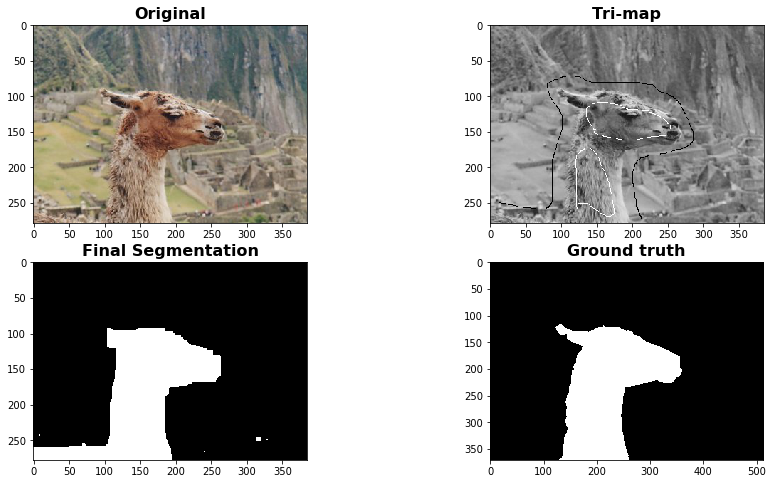

In [34]:
# ------------------- code to get and store new user input ----------------------------#
# image, fgSeeds, bgSeeds, fore, back = getUserInput("./provided_images/llama.jpg")
# tri_map = np.zeros((image.shape[0], image.shape[1], image.shape[2]), dtype=float)
# tri_map[:] = image
# tri_map = np.dot(tri_map, (0.299, 0.587, 0.114))
# tri_map[fore] = 255
# tri_map[back] = 0
# np.save('./user_data/llamaFGseeds', fgSeeds)
# np.save('./user_data/llamaBGseeds', bgSeeds)
# np.save('./user_data/llamaTriMap', tri_map)

# ------------------- code to load previous user input ----------------------#
fgSeeds = np.load('./user_data/llamaFGseeds.npy')
bgSeeds = np.load('./user_data/llamaBGseeds.npy')
tri_map = np.load('./user_data/llamaTriMap.npy')
image = np.load('./user_data/llama.npy')

# ------------------- code to compute the segmentation ------------------------#
answer = segmentation(image, fgSeeds, bgSeeds, 7000, 1578) #lambda, sigmaB

plt.rcParams['figure.figsize'] = [15,8]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'
plt.subplot(221)
plt.title('Original')
plt.imshow(image)

plt.subplot(222)
plt.title('Tri-map')
plt.imshow(tri_map, cmap='gray', vmin=0, vmax=255)

plt.subplot(223)
plt.title('Final Segmentation')
plt.imshow(answer, cmap='gray', vmin=0, vmax=255)

plt.subplot(224)
plt.title('Ground truth')
ground_truth = cv2.imread('./provided_images/ground_truth/llama-seg.png')
gtound_truth = ground_truth[:,:,::-1]
plt.imshow(ground_truth)
plt.show()

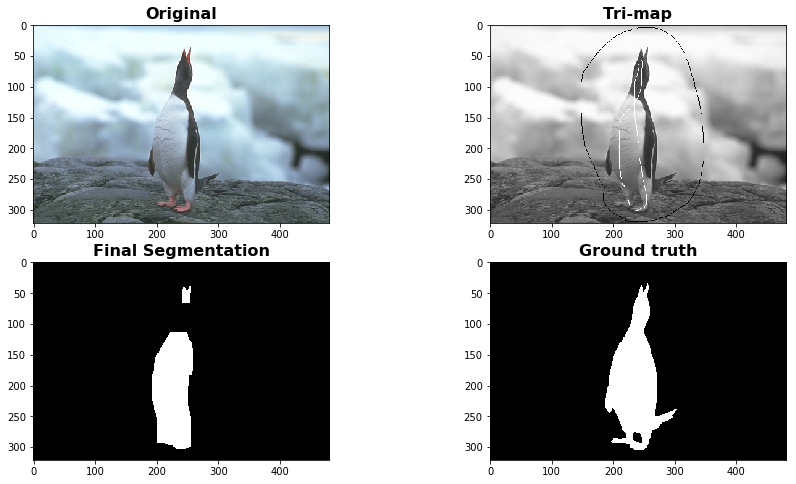

In [44]:
# ------------------- code to get and store new user input ----------------------------#
# image, fgSeeds, bgSeeds, fore, back = getUserInput("./provided_images/penguin.png")
# tri_map = np.zeros((image.shape[0], image.shape[1], image.shape[2]), dtype=float)
# tri_map[:] = image
# tri_map = np.dot(tri_map, (0.299, 0.587, 0.114))
# tri_map[fore] = 255
# tri_map[back] = 0
# np.save('./user_data/penguinFGseeds', fgSeeds)
# np.save('./user_data/penguinBGseeds', bgSeeds)
# np.save('./user_data/penguinTriMap', tri_map)

# ------------------- code to load previous user input ----------------------#
fgSeeds = np.load('./user_data/penguinFGseeds.npy')
bgSeeds = np.load('./user_data/penguinBGseeds.npy')
tri_map = np.load('./user_data/penguinTriMap.npy')
image = np.load('./user_data/penguin.npy')

# ------------------- code to compute the segmentation ------------------------#
answer = segmentation(image, fgSeeds, bgSeeds, 7000, 1578) #lambda, sigmaB

plt.rcParams['figure.figsize'] = [15,8]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'
plt.subplot(221)
plt.title('Original')
plt.imshow(image)

plt.subplot(222)
plt.title('Tri-map')
plt.imshow(tri_map, cmap='gray', vmin=0, vmax=255)

plt.subplot(223)
plt.title('Final Segmentation')
plt.imshow(answer, cmap='gray', vmin=0, vmax=255)

plt.subplot(224)
plt.title('Ground truth')
ground_truth = cv2.imread('./provided_images/ground_truth/penguin-seg.png')
gtound_truth = ground_truth[:,:,::-1]
plt.imshow(ground_truth)
plt.show()

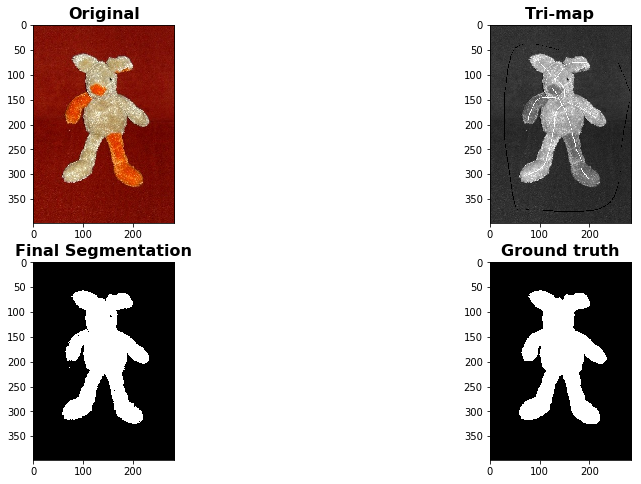

In [27]:
# ------------------- code to get and store new user input ----------------------------#
# image, fgSeeds, bgSeeds, fore, back = getUserInput("./provided_images/teddy.png")
# tri_map = np.zeros((image.shape[0], image.shape[1], image.shape[2]), dtype=float)
# tri_map[:] = image
# tri_map = np.dot(tri_map, (0.299, 0.587, 0.114))
# tri_map[fore] = 255
# tri_map[back] = 0
# np.save('./user_data/teddyFGseeds', fgSeeds)
# np.save('./user_data/teddyBGseeds', bgSeeds)
# np.save('./user_data/teddyTriMap', tri_map)

# ------------------- code to load previous user input ----------------------#
fgSeeds = np.load('./user_data/teddyFGseeds.npy')
bgSeeds = np.load('./user_data/teddyBGseeds.npy')
tri_map = np.load('./user_data/teddyTriMap.npy')
image = np.load('./user_data/teddy.npy')

# ------------------- code to compute the segmentation ------------------------#
answer = segmentation(image, fgSeeds, bgSeeds, 100, 28) #lambda, sigmaB

plt.rcParams['figure.figsize'] = [15,8]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'
plt.subplot(221)
plt.title('Original')
plt.imshow(image)

plt.subplot(222)
plt.title('Tri-map')
plt.imshow(tri_map, cmap='gray', vmin=0, vmax=255)

plt.subplot(223)
plt.title('Final Segmentation')
plt.imshow(answer, cmap='gray', vmin=0, vmax=255)

plt.subplot(224)
plt.title('Ground truth')
ground_truth = cv2.imread('./provided_images/ground_truth/teddy-seg.png')
gtound_truth = ground_truth[:,:,::-1]
plt.imshow(ground_truth)
plt.show()

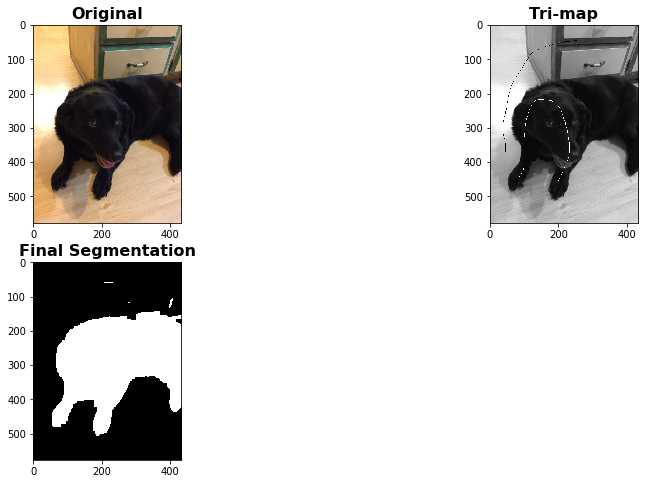

In [33]:
# ------------------- code to get and store new user input ----------------------------#
# image, fgSeeds, bgSeeds, fore, back = getUserInput("./user_data/uva.jpg")
# tri_map = np.zeros((image.shape[0], image.shape[1], image.shape[2]), dtype=float)
# tri_map[:] = image
# tri_map = np.dot(tri_map, (0.299, 0.587, 0.114))
# tri_map[fore] = 255
# tri_map[back] = 0
# np.save('./user_data/uvaFGseeds', fgSeeds)
# np.save('./user_data/uvaBGseeds', bgSeeds)
# np.save('./user_data/uvaTriMap', tri_map)
# np.save('./user_data/uva', image)

# ------------------- code to load previous user input ----------------------#
fgSeeds = np.load('./user_data/uvaFGseeds.npy')
bgSeeds = np.load('./user_data/uvaBGseeds.npy')
tri_map = np.load('./user_data/uvaTriMap.npy')
image = np.load('./user_data/uva.npy')

# ------------------- code to compute the segmentation ------------------------#
answer = segmentation(image, fgSeeds, bgSeeds, 7000, 1578) #lambda, sigmaB

plt.rcParams['figure.figsize'] = [15,8]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'
plt.subplot(221)
plt.title('Original')
plt.imshow(image)

plt.subplot(222)
plt.title('Tri-map')
plt.imshow(tri_map, cmap='gray', vmin=0, vmax=255)

plt.subplot(223)
plt.title('Final Segmentation')
plt.imshow(answer, cmap='gray', vmin=0, vmax=255)
plt.show()

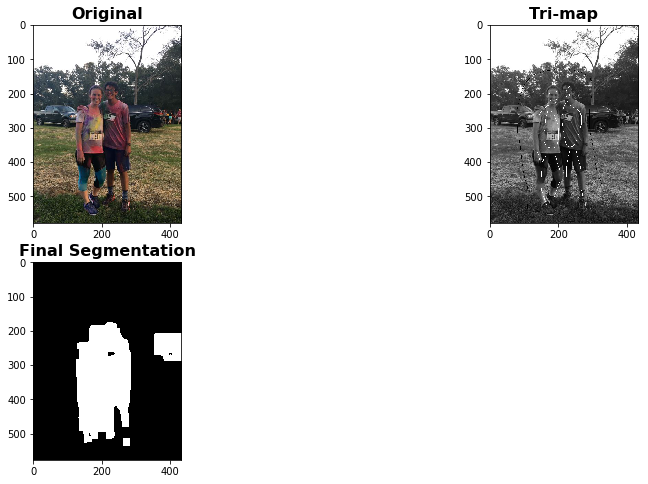

In [43]:
# ------------------- code to get and store new user input ----------------------------#
# image, fgSeeds, bgSeeds, fore, back = getUserInput("./user_data/colorrun.jpg")
# tri_map = np.zeros((image.shape[0], image.shape[1], image.shape[2]), dtype=float)
# tri_map[:] = image
# tri_map = np.dot(tri_map, (0.299, 0.587, 0.114))
# tri_map[fore] = 255
# tri_map[back] = 0
# np.save('./user_data/colorrunFGseeds', fgSeeds)
# np.save('./user_data/colorrunBGseeds', bgSeeds)
# np.save('./user_data/colorrunTriMap', tri_map)

# ------------------- code to load previous user input ----------------------#
fgSeeds = np.load('./user_data/colorrunFGseeds.npy')
bgSeeds = np.load('./user_data/colorrunBGseeds.npy')
tri_map = np.load('./user_data/colorrunTriMap.npy')
image = np.load('./user_data/colorrun.npy')

# ------------------- code to compute the segmentation ------------------------#
answer = segmentation(image, fgSeeds, bgSeeds, 7000, 1878) #lambda, sigmaB

plt.rcParams['figure.figsize'] = [15,8]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'
plt.subplot(221)
plt.title('Original')
plt.imshow(image)

plt.subplot(222)
plt.title('Tri-map')
plt.imshow(tri_map, cmap='gray', vmin=0, vmax=255)

plt.subplot(223)
plt.title('Final Segmentation')
plt.imshow(answer, cmap='gray', vmin=0, vmax=255)
plt.show()

## Explanation on custom pictures
<span>
    <ul>
        <li>
            The picture of my dog Uva in my opinion is easy because Uva is a much different color than her background which makes the foreground and background distributions much different and therefore makes the t-link weights different and easy to seperate. 
        </li>
        <li>
            The picture of my wife and I after a color run is more difficult in my opinion because there are all sorts of colors on us and there's a small group of people in the background who are also colorful which makes them become a part of the "foreground" when really they're meant to be part of the background. Talk about a photo bomb.
        </li>
    </ul>
</span>


## Grading / Rubric
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Code that correctly generates the graph network structure (nodes, n-links, t-links).
* [10 pts] Code that produces the boundary term $B(p,q)$ used for n-links.
* [10 pts] Code that produces the region term of the cost $R(p,A)$ used for the t-links.  Remember that you have t-links per pixel, one with cost determined by matching $p$ with the foreground appearance distribution, the other determined relative to the background distribution.  You may use the [sk-learn implementation](https://scikit-learn.org/stable/modules/density.html#kernel-density-estimation) of Kernel Density Estimation.  However you will receive 10 extra points if you implement it yourself.
* [20 pts] Implementing the graph-cut with `pymaxflow` and finding the optimal solution for the input graph.
* [10 pts] Displaying Results in the following format (for each input image you'll show the following 3-4 result images):
   1. Original Image.
   2. Tri-map of what was selected by the user (white for foreground, black for background, gray for unknown).  This can be overlaid on top of a faint copy of the image for context if desired.
   3. Final segmentation.  Again you can overlay it on a faint copy of the original for context.
   4. On the <i>provided images</i> please show a comparison of your resulting segmentaiton with the ground truth.
* [20 pts] Good (certainly not perfect, some of them are challenging, but decent/reasonable) results on the 4 provided images (banana, llama, penguin, teddy).  Each image will receive up to 5 points.
* [10 pts] Demonstrating your algorithm on 2-4 additional images.  At least one of the images should be somewhat easy, one should be somewhat challenging -- expalin why you think they're respectively easy/challenging.


## Write-up:
Provide an explanation for the following items:
* Describe how you determinied/computed the n-link and t-link weights.
* What kinds of image does graph cut segmentation work well for? What kinds of images do you find it struggles with?
* What did you learn from the project?
* What if any suggestions do you have for improving it (for future students)?

<span>
    <ul>
        <li> I computed the n-links by starting in the top left corner of the image, then, row by row, column by column, comparing one pixel to it's right neighbor and down neighbor (if there was one). I then found the norm of the two pixels' rgb values. I then used this value as the ||Ip - Iq|| value in the boundary term formula. I then added this value as an edge from pixel p to q and vice versa.<br>To calculate the t-link weights, I first made a 3d gaussian distribution of the foreground and background seeds using the sk-learn package. Next I iterated throught the pixels as I did for finding the boundary terms, and for each pixel, I calculated the negative log-likelihood by using the "score" method on the package and negating that. I then added this value as edge from/to the source/sink nodes, depending on the distribution.</li>
        <li>Graph cut segmentation works well on images whose foregrounds are different colors then their backgrounds. Take the penguin image for example, since the penguin in black and white, and it's background is somewhat black and white, their foreground/background distributions are similar, and when finding the t-link weights, it's difficult to distinguish if a pixel belongs to the foreground or background. On an image like the one of my dog for example, the dog is black, and the background is not black except for a few shadows. The distributions are quite different, making assignment easier for t-link weights.</li>
        <li>I learned that using existing libraries for big chunks of a project can be tricky and may not result in the values you are expecting. After using the score method I was shocked to see the values with such great magnitude and it was hard to find values of lambda and sigma which would account for these large values. I also learned that moulding a new problem into a previously solved problem can prove to be really cool! For example, the min cut/max flow problem had been solved previous to the segmentation method, it was only after interpreting pixels into a graph that fit the min cut/max flow problem that simplified finding the foreground and background.</li>
        <li>I don't really have any suggestions, I think the info was pretty clear and slack helped alot to get questions answered.</li>
    </ul>
</span>